<a href="https://colab.research.google.com/github/vkjadon/AI-ipynb/blob/master/13LRModelCatNoCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression based on Fundamental Approach
- Will use `kaggle` dataset of cat.
- This is based on the assignment of **Week-2** of **Deep Learning** Course by `Andrew Ng`

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

### Fetch Dataset from Kaggle
- Import data from Kaggle
- Use <a href="https://www.kaggle.com/muhammeddalkran/catvnoncat" target="_blank"> this Link </a>  

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

In [2]:
!ls

drive  sample_data


In [3]:
!pwd

/content


In [4]:
% cd drive/MyDrive/Colab Notebooks/AI-ipynb

/content/drive/MyDrive/Colab Notebooks/AI-ipynb


It throw error because the drive is not accessible to the colab. For this we have to mount the drive using the `Mount Drive` icon. It will ask for the permission which we have to allow so that Colab can access the Drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
% cd drive/MyDrive/Colab Notebooks/AI-ipynb

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/AI-ipynb'
/content/drive/MyDrive/Colab Notebooks/AI-ipynb


In [7]:
# Loading the data (cat/non-cat) from the File downloaded from the Kaggle
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

In [8]:
for key in train_dataset.keys():
    print(key) #Names of the groups in HDF5 file.

list_classes
train_set_x
train_set_y


In [9]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

In [10]:
print(train_set_x_orig.shape)
print(train_set_y.shape)

(209, 64, 64, 3)
(209,)


In [11]:
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

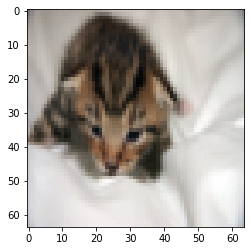

In [12]:
index = 1
plt.imshow(test_set_x_orig[index])

In [13]:
train_set_y.shape

(209,)

In [14]:
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

In [15]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64


In [16]:
train_set_x_orig.shape

(209, 64, 64, 3)

The shape of **`X`** matrix is $\mathcal {(nx, m)}$ where each columns represents the features of each training set; 

Where,   

$\mathcal {nx=px * py * 3}$ for the images as input and $m$ is the training examples.



So, we have to reshape to `train_set_x_orig` to `(nx,m_train)`. This will be achieved in two steps:   

***Step-1*** : Respahe `train_set_x_orig` to `(train_set_x_orig.shape[0],-1)`. -1 is used for unknown number of columns (known presently as `nx`)   
***Step-2*** : Transpose the matrix to get the desired dimension `(nx, m)`.

In [17]:
train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape (test_set_x_orig.shape[0],-1).T

In [18]:
train_set_x_flatten.shape

(12288, 209)

Optimizing the parameters is best suited on the data of the same range. Let's normalize our dataset with the maximum possible pixel value i.e. 255.

In [19]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.
features=train_set_x.shape[0]
features

12288

## Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate loss (forward propagation)
    - Calculate gradient (backward propagation)
    - Update parameters (gradient descent)


In [20]:
def sigmoid(z):
#    z -- A scalar or numpy array of any size.
    s=1/(1+np.exp(-z))
    return s

##  Parameter Initialization

Let us make a function to creates a vector of zeros of shape (nx, 1) for w and initializes b to 0.

In [21]:
def initialize_with_zeros(nx):
    w=np.zeros(nx).reshape(nx,1)
    b=0.0
    return w, b

Implement the cost function and its gradient for the propagation. It should return:   
 - cost for logistic regression
 - gradient of the loss with respect to w
 - gradient of the loss with respect to b

In [22]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A=sigmoid(np.dot(w.T,X)+b)
    cost=-np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1)/m

    # BACKWARD PROPAGATION (TO FIND GRAD)

    dw=np.dot(X,(A-Y).T)/m
    db=(np.sum((A-Y), dtype=np.float64))/m

    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [23]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)        
        dw = grads["dw"]
        db = grads["db"]
        w=w-learning_rate*dw
        b=b-learning_rate*db

        if i % 500 == 0:
            costs.append(cost)
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [24]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A=sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):    
        if A[0,i] > 0.5:
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
    return Y_prediction

In [25]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.1, print_cost=False):

    w, b=np.zeros(X_train.shape[0]).reshape(X_train.shape[0],1),0.0
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    Y_prediction_train=predict(params["w"], params["b"], X_train)
    Y_prediction_test=predict(params["w"], params["b"], X_test)

    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
        print("learning Rate ", learning_rate)

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : params["w"], 
         "b" : params["b"],
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [26]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=5000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.303273
Cost after iteration 1000: 0.214820
Cost after iteration 1500: 0.166521
Cost after iteration 2000: 0.135608
Cost after iteration 2500: 0.114093
Cost after iteration 3000: 0.098280
Cost after iteration 3500: 0.086190
Cost after iteration 4000: 0.076662
Cost after iteration 4500: 0.068968
train accuracy: 100.0 %
test accuracy: 70.0 %
learning Rate  0.005


In [31]:
logistic_regression_model["Y_prediction_test"]

array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 0.]])

In [33]:
test_set_y

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

In [54]:
for index in range(test_set_y.shape[1]):
  true_label=test_set_y[0][index]
  model_label=logistic_regression_model["Y_prediction_test"][0][index]
  if(true_label!=model_label):
    if(true_label==0):
      print("A Non Cat image predicted as Cat False Positive",index, true_label, model_label)
    else:
      print("A Cat image predicted as Non Cat False Negative",index, true_label, model_label)
  index=index+1  

A Non Cat image predicted as Cat False Positive 5 0 1.0
A Cat image predicted as Non Cat False Negative 6 1 0.0
A Cat image predicted as Non Cat False Negative 10 1 0.0
A Cat image predicted as Non Cat False Negative 11 1 0.0
A Non Cat image predicted as Cat False Positive 13 0 1.0
A Cat image predicted as Non Cat False Negative 18 1 0.0
A Cat image predicted as Non Cat False Negative 19 1 0.0
A Cat image predicted as Non Cat False Negative 28 1 0.0
A Non Cat image predicted as Cat False Positive 29 0 1.0
A Cat image predicted as Non Cat False Negative 30 1 0.0
A Non Cat image predicted as Cat False Positive 34 0 1.0
A Cat image predicted as Non Cat False Negative 41 1 0.0
A Non Cat image predicted as Cat False Positive 44 0 1.0
A Non Cat image predicted as Cat False Positive 45 0 1.0
A Cat image predicted as Non Cat False Negative 46 1 0.0


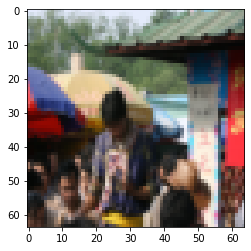

In [59]:
plt.imshow(test_set_x[:, 34].reshape((num_px, num_px, 3)))

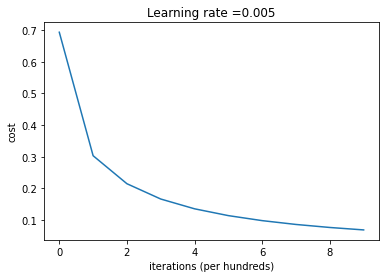

In [28]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()